---
title: "Using Python to construct dollar indices"
author: "Alejandro Pérez Sanjuán"
date: 2021-07-09
categories: [finance, python]
format: html
---

In this post we review the methodology for constructing 2 dollar indices. We also code simple procedures to obtain those indices programmatically. Finally, we propose a method to compute a USD dollar index using PCA.

In [1]:
# dependencies we are going to need
import investpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from functools import reduce
from typing import Dict, Union

In [2]:
#hide
plt.style.use('https://gist.githubusercontent.com/Xylambda/4521dc6404594a715bbc7b75e8c1e2e1/raw/f4f466b27955169abd934428ed98c2be2e1201f2/bpyplot')

## Introduction
In order to track the strength of the dollar, different organizations have developed different techniques to create their own dollar indexes. In this post we are going to see 2 methodologies to construct dollar indexes plus an extra one with PCA, though we will not discuss the results (at least in this post).

The most common way of constructing an index is by weighting the currency to track against a set of ponderated currencies. The currencies basket, the way weights are chosen and how we aggregate the different ponderated currencies define how we construct an index.

## Dollar indices
### USDIDX
The dollar index is an index that measures the U.S. dollar value. It is built using a geometric mean of the following currencies with their respective weights:
* **Euro (EUR):** 57.6 % weight
* **Japanese yen (JPY):** 13.6 % weight.
* **Pound sterling (GBP):** 11.9 % weight.
* **Canadian dollar (CAD):** 11.9 % weight.
* **Swedish krona (SEK):** 4.2 % weight.
* **Swiss franc (CHF):** 3.6 % weight.

In the case of the main U.S. dollar index the weights remain static, which does not allow the index to capture well some market conditions. Furthermore, we see the Swedish Krona taking a relatively high weight, which is certainly outdated in the current market context.


### Trade weighted U.S. dollar index
In 1998, the staff of the Federal Reserve Board introduced a new set of indices, among which was the trade weighted dollar index.

Although the dollar index is not well suited to capture rapid market movements (among other things), the trade weighted U.S. dollar index is not designed to fix this issue but to measure the strenght of the U.S. economy with respect to its trading partners.

According to Loretan [1], the Federal Reserve Board's nominal dollar index at time $t$ can be defined as
$$
I_{t} = I_{t-1} \cdot \prod_{j=1}^{N(t)} \left( \dfrac{e_{j,t}}{e_{j,t-1}} \right)^{w_{j,t}}
$$

Let's break the formula to understand each one of the terms:
* $I_{t-1}$ is the value of the index at time $t-1$.
* $e_{j,t}$ and $e_{j,t-1}$ are the prices of the U.S. dollar in terms of foreign currency $j$ at times $t$ and $t-1$.
* $w_{j,t}$ is the weight of currency $j$ at time $t$.
* $N(t)$ is the number of foreign currencies in the index at time $t$.
* $\sum_{j}w_{j,t} = 1$. 

Notice how the index is computed using a geometric weighted average. As Loretan explains in [1], this is done because geometric averaging forces proportionately equal appreciation and depreciation of currencies to have the same numerical effect.

The weights $w_{j,t}$ are computed as

$$
w_{j,t} = \frac{1}{2} \mu_{US,j,t} + \frac{1}{2} \left( \frac{1}{2} \epsilon_{US, j,t} + \frac{1}{2} \tau_{US,jt} \right)
$$

which is nothing more than a linear combination of three submeasures of the degree of trade competition. 

In the formula above, we can identify some terms that need further explanation:

* $\mu_{US,j,t} = M_{US,j,t} / \sum_{j=1}^{N(t)}M_{US, j,t}$ is the economy's bilateral import weight during period $t$. Here, $M_{US,j,t}$ represents the merchandise imports from economy $j$ to the USA in year $t$.

* $\epsilon_{US, j,t} = X_{US,j,t} / \sum_{j=1}^{N(t)}X_{US,j,t}$ accounts for the US bilateral export share, where $X_{US,j,t}$ represents the merchandise exports from the USA to economy $j$ in year $t$.

* $\tau_{US,j,t} = \sum_{k \neq j, k \neq US}^{N(t)} \epsilon_{US, j,t} \cdot \mu_{k,j,t} / (1 - \mu_{j,j,t})$ measures a form of competition where US-produced goods may also compete with goods produced in economy $j$ if the USA and economy $j$ both export goods to buyers in third-market economies. Here, $\mu_{k,j,t}$ is the fraction of economy $k$'s merchandise imports from country $j$ in year $t$. The factor $1 / (1 - \mu_{j,j,t})$ is used to ensure weights sum up to 1.

Fortunately for us, we don't have to manually compute the weights since they can be found at the Federal Reserve Board [4].

## Constructing dollar indices in Python
### US dollar index
We first start with the US dollar index. The construction is pretty simple since it is just a geometric weighted mean. The formula to compute the index is:
$$
USDIDX = 50.14348112 \cdot EURUSD^{-0.576} \cdot USDJPY^{0.136} \cdot GBPUSD^{-0.119} \cdot USDCAD^{0.091} \cdot USDSEK^{0.042} \cdot USDCHF^{0.036}
$$

Notice how the sign of the exponent changes to account for the direction in which the currencies are expressed: if the USD is the base currency, the exponent is positive.

The number `50.14348112` is a correction factor to force the index to start at value 100.

In [3]:
#hide
crosses = [
    'AUD/USD', # Australia
    'USD/ARS', # Argentina
    'USD/BRL', # Brazil
    'USD/CAD', # Canada
    'USD/CNY', # China
    'USD/CLP', # Chile
    'USD/COP', # Colombia
    'USD/HKD', # Hong Kong
    'USD/IDR', # Indonesia
    'USD/INR', # India
    'USD/ILS', # Israel
    'USD/JPY', # Japan
    'USD/KRW', # Korea
    'USD/MYR', # Malaysia
    'USD/MXN', # Mexico
    'USD/PHP', # Philippines
    'USD/RUB', # Russia
    'USD/SAR', # Saudi Arabia
    'USD/SEK', # Sweeden
    'USD/SGD', # Singapore
    'USD/CHF', # Switzerland
    'USD/TWD', # Taiwan
    'USD/THB', # Thailand
    'GBP/USD', # United Kingdom
    'USD/VND', # vietnam
    'EUR/USD' # Euro/Area
]

# download
crosses_dict = {}
for cross in crosses:
    data = investpy.get_currency_cross_historical_data(
        currency_cross=cross,
        from_date='01/01/1950',
        to_date='01/01/2022'
    )
    
    crosses_dict[cross] = data[['Open', 'High', 'Low', 'Close']]#.loc['1988-03-04':]

In [4]:
#collapse-show
def dollar_index(
    currencies: Dict[str, pd.DataFrame], 
    weights: Dict[str, float]
) -> Union[pd.DataFrame, pd.Series]:
    """Compute the main U.S. dollar index.
    
    Weights must account for the currency cross direction.
    
    Parameters
    ---------
    currencies : dict
        Dictionary containing the currency prices.
    weights : dict
        Dictionary containing the weights of each currency.
        
    Returns
    -------
    idx : pandas.DataFrame
        U.S. dollar index.
    """
    new = {}
    
    idx_crosses = ['EUR/USD', 'USD/JPY', 'GBP/USD', 'USD/CAD', 'USD/SEK', 'USD/CHF']
    
    # ponderate each currency
    for key in idx_crosses:
        new[key] = currencies[key] ** weights[key]
        
    # multiply all currencies
    idx = reduce(
        lambda a, b: a.multiply(b),
        [new[key] for key in new.keys()]
    )
    
    # add correction factor
    idx *= 50.14348112
    
    return idx

<AxesSubplot:title={'center':'USD IDX'}, xlabel='Date'>

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


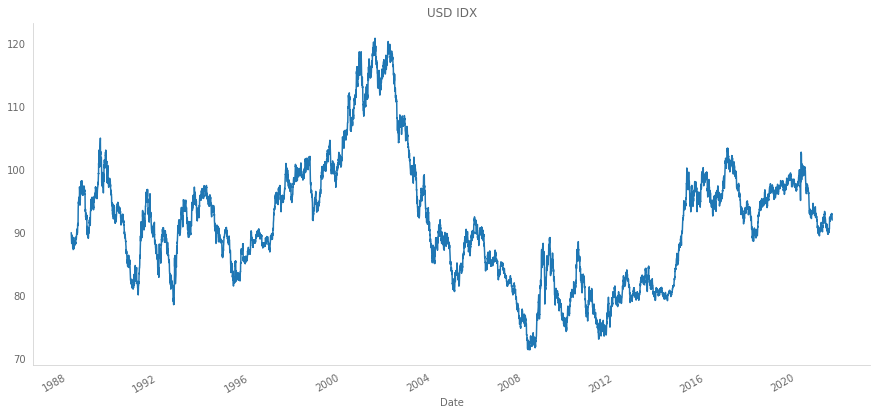

In [5]:
# create weights dictionary
idx_crosses = ['EUR/USD', 'USD/JPY', 'GBP/USD', 'USD/CAD', 'USD/SEK', 'USD/CHF']
dollar_idx_weights = dict(zip(idx_crosses, [-0.576, 0.136, -0.119, 0.091, 0.042, 0.036]))

# compute the us dollar index
usdidx = dollar_index(crosses_dict, dollar_idx_weights)
usdidx['Close'].plot(figsize=(15,7), title='USD IDX')

### Trade weighted dollar index
In order to get the weights quickly and in a simple way, we can just copy the table from [4] and use Pandas to read our clipboard.

In [6]:
#collapse-show
weights = pd.read_clipboard()
weights.set_index('Country or Region', inplace=True)
weights.index = crosses + ['Total'] # put currency names instead of country names

In [7]:
weights

,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006
AUD/USD,1.401,1.401,1.401,1.416,1.453,1.443,1.539,1.557,1.596,1.749,1.674,1.549,1.639,1.480,1.364,1.309
USD/ARS,0.442,0.442,0.442,0.495,0.550,0.524,0.510,0.479,0.530,0.507,0.513,0.469,0.447,0.456,0.380,0.359
USD/BRL,1.932,1.932,1.932,1.952,2.010,1.903,2.080,2.338,2.426,2.428,2.448,2.194,2.051,2.114,1.857,1.779
USD/CAD,13.337,13.337,13.337,13.467,13.685,13.873,14.062,15.120,15.513,15.645,15.883,16.078,15.844,17.406,18.089,18.613
USD/CNY,13.719,13.719,13.719,15.767,16.014,15.635,15.862,15.645,15.564,15.099,14.798,14.848,14.035,13.009,12.839,12.326
USD/CLP,0.640,0.640,0.640,0.642,0.633,0.621,0.651,0.637,0.706,0.731,0.701,0.606,0.611,0.610,0.586,0.600
USD/COP,0.615,0.615,0.615,0.624,0.598,0.610,0.653,0.704,0.661,0.670,0.659,0.650,0.678,0.666,0.591,0.552
USD/HKD,1.330,1.330,1.330,1.438,1.489,1.433,1.420,1.450,1.418,1.314,1.349,1.317,1.332,1.233,1.246,1.239
USD/IDR,0.665,0.665,0.665,0.669,0.678,0.668,0.698,0.726,0.762,0.737,0.770,0.747,0.699,0.679,0.616,0.597
USD/INR,2.869,2.869,2.869,2.800,2.674,2.627,2.458,2.310,2.264,2.228,2.220,2.120,2.069,1.917,1.746,1.499


In [9]:
#collapse-show
def trade_weighted_usdidx(currencies: Dict[str, pd.DataFrame], weights: pd.DataFrame) -> pd.DataFrame:
    """
    Compute trade weighted dollar index.
    
    Parameters
    ----------
    currencies : dict
        Dictionary containing all currency crosses.
    weights : pandas.DataFrame
        DataFrame containing the weights for each cross. The columns
        should be years while the index should be the crosses.
        
    Returns
    -------
    idx : pd.DataFrame
        Trade weighted dollar index.
    """
    ponderated_crosses = {}
    
    for cross in currencies.keys():
        
        ponderations_per_year = []
        
        for year in weights.columns:
            # invert prices if needed
            if not cross.startswith('USD'):
                prices = (1 / currencies[cross]).loc[str(year)]
            else:
                prices = currencies[cross].loc[str(year)]
                
            returns = prices / prices.shift(1)
            weight = weights.loc[cross, year] / 100
            
            ponderations_per_year.append(returns ** weight)
        
        ponderated_crosses[cross] = pd.concat(ponderations_per_year)
            
    # multiply all currencies
    idx = reduce(
        lambda a, b: a.multiply(b),
        [ponderated_crosses[key] for key in ponderated_crosses.keys()]
    )
    
    idx.iloc[0, :] = 100
    
    return idx.cumprod()

Since we could not retrieve the USD/SAR prices for the year 2021, we will only compute the index from 2006 to 2020.

<AxesSubplot:title={'center':'Trade weighted dollar index'}, xlabel='Date'>

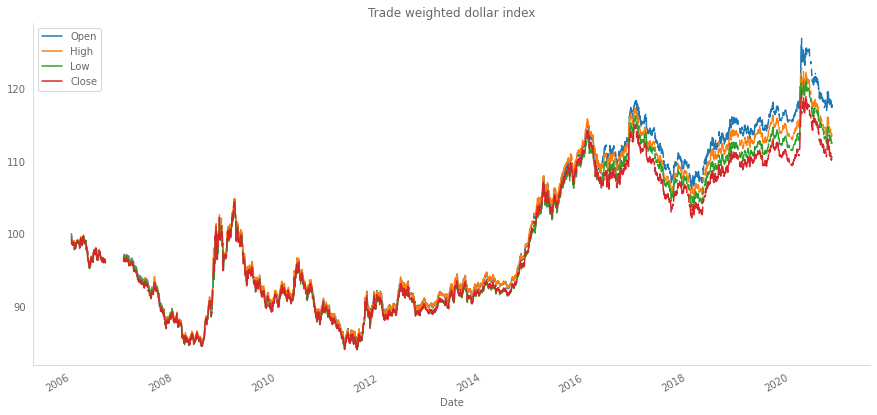

In [10]:
fed_idx = trade_weighted_usdidx(currencies=crosses_dict, weights=weights.drop('2021', axis=1))
fed_idx.plot(figsize=(15,7), title='Trade weighted dollar index')

### Build your own index
`Note:` this idea was inspired by [2] and [6].

In this section, we will code a simple index using PCA to compute the weights of the currencies. The idea is to reduce the space into 1 component and then grab the loadings (projected eigenvalues) to use them as weights.

The ideal procedure will compute PCA using a rolling window, but I am gonna leave that as an exercise for the reader **;)**.

In [11]:
#collapse
closes = []
for cr in crosses_dict.keys():
    closes.append(crosses_dict[cr].loc[:, 'Close'])
    
closes = pd.concat(closes, axis=1)
closes.columns = crosses_dict.keys()

We will apply PCA over the logarithmic daily returns.

In [12]:
returns = closes.apply(np.log).diff(1)
pca = PCA(n_components=1)
pca.fit(returns.dropna())

PCA(n_components=1)

Now, Scikit-Learn stores an eigenvector, for each principal component, for the projection space. We can use these values as our weights. Below there is a plot showing the values for these weights.

<AxesSubplot:title={'center':'Weights'}>

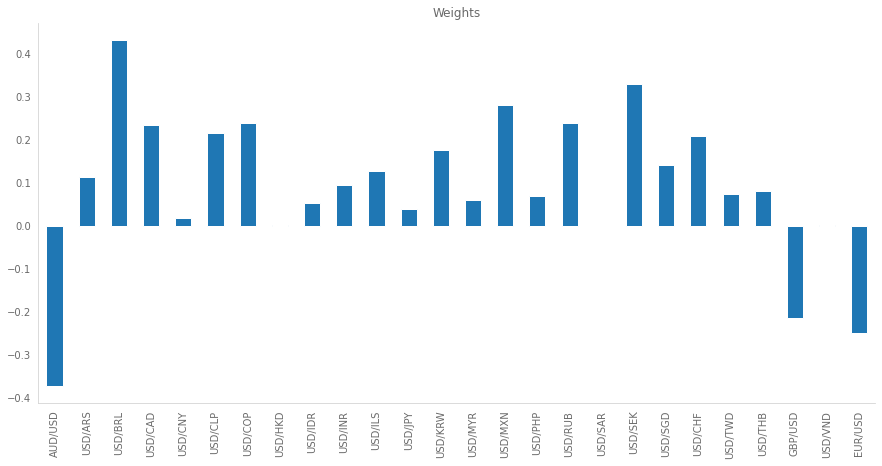

In [14]:
weights_pca = pd.Series(index=returns.columns, data=pca.components_[0])
weights_pca.plot.bar(figsize=(15,7), title='Weights')

Notice how PCA is able to capture the sign of the returns: if the direction is XXX/USD, the weights are negative. Another thing to take into account is the fact that, generally, the crosses with the lowest weights are pegged currencies (USD/CNY, USD/HKD, USD/SAR, USD/VND).

Going back to the procedure, since the PCA weights do not sum up to 1, we have to normalize them but taking into account the sign:

<AxesSubplot:title={'center':'Fixed Weights'}>

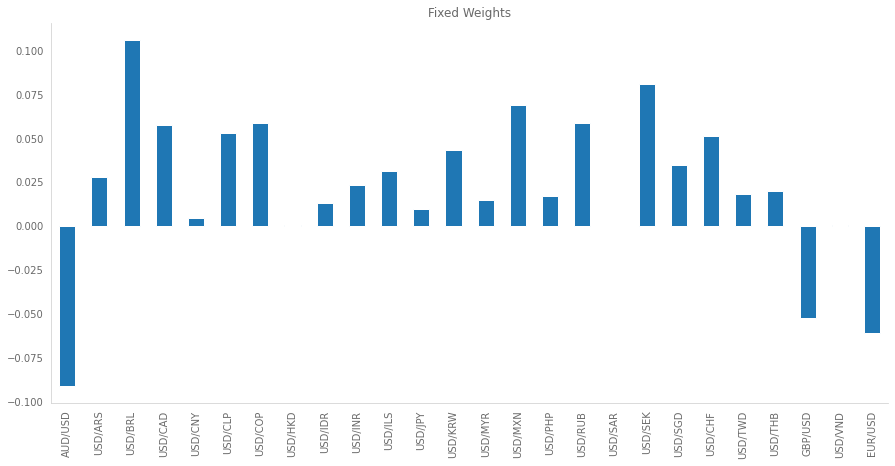

In [15]:
weights_pca = (weights_pca / weights_pca.abs().sum())
weights_pca.plot.bar(figsize=(15,7), title='Fixed Weights')

In [16]:
#collapse-show
def pca_dollar_index(
    currencies: Dict[str, pd.DataFrame], 
    weights: Dict[str, float]
) -> Union[pd.DataFrame, pd.Series]:
    """Compute dollar index using PCA.
    
    Weights must account for the currency cross direction.
    
    Parameters
    ---------
    currencies : dict
        Dictionary containing the currency prices.
    weights : dict
        Dictionary containing the weights of each currency.
        
    Returns
    -------
    idx : pandas.DataFrame
        U.S. dollar index.
    """
    new = {}
    
    # ponderate each currency
    for key in idx_crosses:
        new[key] = currencies[key] ** weights[key]
        
    # multiply all currencies
    idx = reduce(
        lambda a, b: a.multiply(b),
        [new[key] for key in new.keys()]
    )
    
    norm_factor = 100 / idx['Close'].dropna().iloc[0]
    idx *= norm_factor
    
    return idx

The operation `norm_factor = 100 / idx['Close'].dropna().iloc[0]` is used to force the first day to be 100, as in the other indices.

<AxesSubplot:title={'center':'PCA Index'}, xlabel='Date'>

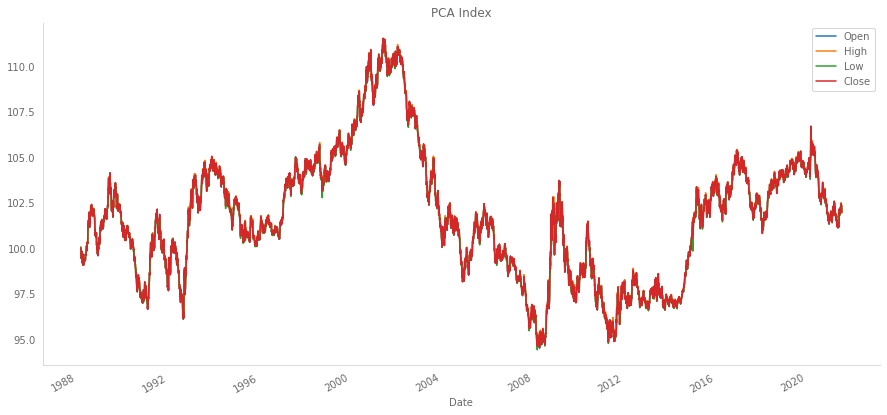

In [17]:
pca_index = pca_dollar_index(crosses_dict, weights_pca)
pca_index.plot(figsize=(15,7), title='PCA Index')

Putting all together we can see how the indices evolve:

<AxesSubplot:xlabel='Date'>

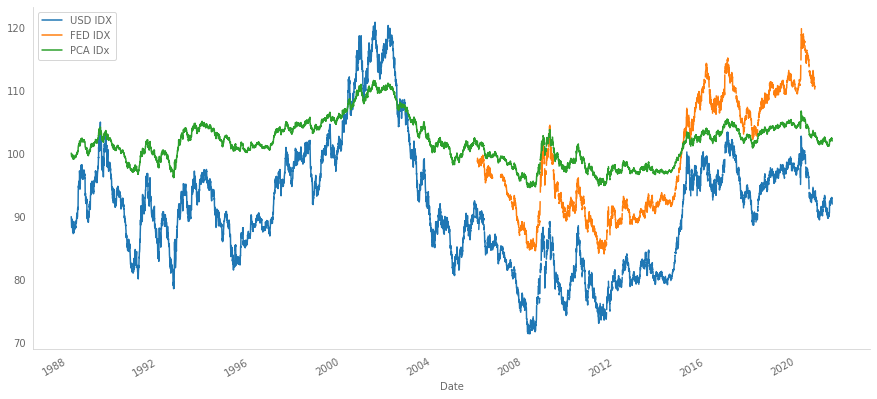

In [18]:
#collapse
all_indices = pd.concat(
    [usdidx['Close'], fed_idx['Close'], pca_index['Close']],
    axis=1
)
all_indices.columns = ['USD IDX', 'FED IDX', 'PCA IDx']
all_indices.plot(figsize=(15,7))

And their correlations

<AxesSubplot:>

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


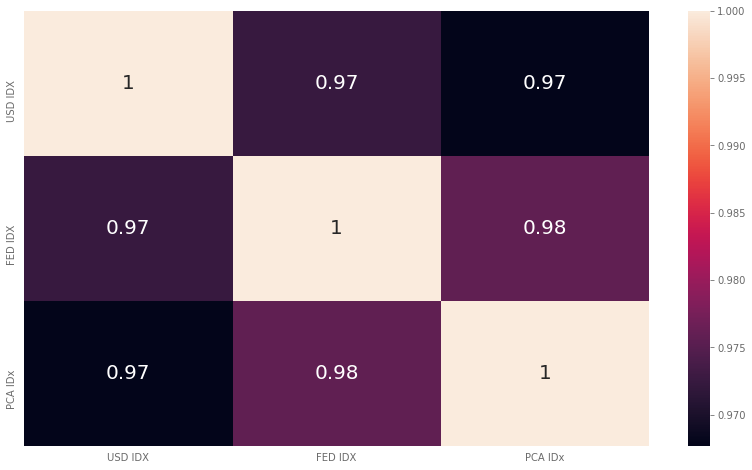

In [19]:
#collapse-hide
plt.figure(figsize=(14,8))
sns.heatmap(all_indices.corr(), annot=True, annot_kws={'fontsize':20})

As expected, all indices are highly correlated, which means they have a strong linear codependence.

## Conclusions
In this post we've reviewed 3 ways of computing a dollar index:
* **USDIDX**: the most common dollar index.

* **Trade weighted dollar index**: an index designed by the USA Federal Reserve to measure how well is USA performing in relation to its trading parters.

* **PCA index**: based on [2] and [6], which is an index whose weights have been computed depending on the eigenvalues of the covariance matrix of the closing prices returns.

The construction of the indices is not perfect in the sense that they don't replicate the true values of the indices. This is due to the lack of data on some days plus a difference in the prices caused by the subset of the market that was used to get the prices not being the same (probably).

An additional analysis will have to be carried out to check which is index is better, but that is out of the scope of this post. You can check [7] to have an idea of how to evaluate the goodness of an index, though it will depend on the use case.

## References
* [1] [Mico Loretan - Indexes of the Foreign Exchange Value of the Dollar](https://www.federalreserve.gov/pubs/bulletin/2005/winter05_index.pdf)

* [2] [Musa Essayyad, Khaled Albinali and Omar Al-Titi - Constructing an alternative dollar index to gauge the movements in currency markets](https://www.researchgate.net/publication/227440018_Constructing_an_alternative_dollar_index_to_gauge_the_movements_in_currency_markets)

* [3] [The Ice - U.S. Dollar Index Contracts](https://www.theice.com/publicdocs/futures_us/ICE_Dollar_Index_FAQ.pdf)

* [4] [Federal Reserve Board - Total Trade Weights](https://www.federalreserve.gov/releases/h10/weights/)

* [5] [S&P Dow Jones Indices: Index Methodology](https://www.spglobal.com/spdji/en/documents/methodologies/methodology-dj-fxcm.pdf)

* [6] [Yao Lei Xu - Stock Market Analytics with PCA.](https://towardsdatascience.com/stock-market-analytics-with-pca-d1c2318e3f0e)

* [7] [Cerno Capital - Is the US Dollar Index Fit for Purpose](https://cernocapital.com/us-dollar-index-fit-purpose)